In [2]:
%matplotlib inline


# Fundamentos de Autograd

La característica Autograd de PyTorch es parte de lo que hace a PyTorch flexible y rápido para construir proyectos de aprendizaje automático. Permite el cálculo rápido y sencillo de múltiples derivadas parciales (también llamadas gradientes) sobre un cálculo complejo. Esta operación es fundamental para el aprendizaje de redes neuronales basado en la retropropagación.

El poder de autograd viene del hecho de que traza su computación dinámicamente en tiempo de ejecución, lo que significa que si su modelo tiene ramas de decisión, o bucles cuyas longitudes no se conocen hasta el tiempo de ejecución, la computación seguirá siendo trazada correctamente, y obtendrá gradientes correctos para impulsar el aprendizaje. Esto, combinado con el hecho de que sus modelos se construyen en Python, ofrece mucha más flexibilidad que los marcos que se basan en el análisis estático de un modelo más rígidamente estructurado para calcular los gradientes.


## ¿Para qué necesitamos Autograd?


Un modelo de aprendizaje automático es una *función*, con entradas y salidas. Para esta discusión, trataremos las entradas como un vector *i*-dimensional $\vec{x}$, con elementos $x_{i}$. Entonces podemos expresar el modelo, *M*, como una función de valor vectorial de la entrada: $\vec{y} = \vec{M}(\vec{x})$. (Tratamos el valor de la salida de M como un vector porque, en general, un modelo puede tener cualquier número de salidas).

Como hablaremos de autograd en el contexto del entrenamiento, nuestra salida de interés será la pérdida del modelo. La *función de pérdida* L($\vec{y}$) = L($\vec{M}$ ($\vec{x}$)) es una función escalar de un solo valor de la salida del modelo. Esta función expresa cuánto se alejó la predicción de nuestro modelo de la salida *ideal* de una entrada particular. *Nota: Después de este punto, a menudo omitiremos el signo signo de vector donde debe ser contextualmente claro - por ejemplo,* $y$ en lugar de $\vec y$.

En el entrenamiento de un modelo, queremos minimizar la pérdida. En el caso idealizado de un modelo perfecto, eso significa ajustar sus pesos de aprendizaje -es decir, los parámetros ajustables de la función- de forma que la pérdida sea cero para todas las entradas. En el mundo real, significa un proceso iterativo de ajuste de los pesos de aprendizaje hasta que veamos que obtenemos una pérdida tolerable para una amplia variedad de entradas.

¿Cómo decidimos hasta dónde y en qué dirección modificar los pesos? Queremos *minimizar* la pérdida, lo que significa hacer su primera derivada con respecto a la entrada igual a 0: $\frac{\partial L}{\partial x} = 0$.

Recordemos, sin embargo, que la pérdida no es *directamente* derivada de la entrada, sino una función de la salida del modelo (que es una función de la entrada directamente), $\frac{\partial L}{\partial x}$ =
$\frac{\partial {L({\vec y})}}{\partial x}$. Por la regla de la cadena del cálculo diferencial, tenemos $\frac{\partial {L({\vec y})}}{\partial x}$ =
$\frac{\partial L}{\partial y}\frac{\partial y}{\partial x}$ =
$\frac{\partial L}{\partial y}\frac{\partial M(x)}{\partial x}$.

$\frac{\partial M(x)}{\partial x}$es donde las cosas se ponen complejas. Las derivadas parciales de las salidas del modelo con respecto a su entradas, si tuviéramos que ampliar la expresión utilizando la regla de la cadena de nuevo, implicaría muchas derivadas parciales locales sobre cada peso de aprendizaje cada peso de aprendizaje multiplicado, cada función de activación y cualquier otra en el modelo. La expresión completa para cada una de estas derivada parcial es la suma de los productos del gradiente local de *cada camino posible posible* a través del gráfico de cálculo que termina con la variable cuyo gradiente intentamos medir.

En particular, nos interesan los gradientes sobre los pesos de aprendizaje nos dicen *en qué dirección cambiar cada peso* para que la función de pérdida se acerque a cero. para que la función de pérdida se acerque a cero.

Dado que el número de tales derivadas locales (cada una correspondiente a un de cálculo del modelo) tenderá a aumentar exponencialmente con la profundidad de un modelo neuronal. exponencialmente con la profundidad de una red neuronal, también lo hace la complejidad para calcularlas. Aquí es donde entra en juego autograd: Rastrea el historial de cada cálculo. Cada tensor computado en tu modelo PyTorch lleva un historial de sus tensores de entrada y la función usada para crearlo. Combinado con el hecho de que las funciones PyTorch destinadas a actuar sobre tienen cada una una implementación incorporada para calcular sus propias derivadas, esto acelera enormemente el cálculo de las derivadas locales necesarias para el aprendizaje. derivadas locales necesarias para el aprendizaje. 

## Un ejemplo sencillo

Esto ha sido mucha teoría, pero ¿cómo se utiliza autograd en la práctica?

Empecemos con un ejemplo sencillo. Primero, haremos algunas importaciones
para poder representar gráficamente nuestros resultados:

In [2]:
# %matplotlib inline

import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

A continuación, vamos a crear un tensor de entrada lleno de valores espaciados uniformemente en el intervalo $[0, 2{\pi}]$, y especificar ``requires_grad=True``. (Como la mayoría de las funciones que crean tensores, ``torch.linspace()`` acepta una opción ``requires_grad``). Establecer esta bandera significa que en cada cálculo que siga, autograd irá acumulando el historia del cálculo en los tensores de salida de ese cálculo.


In [3]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


A continuación, realizaremos un cálculo y graficaremos su resultado en función de sus entradas:


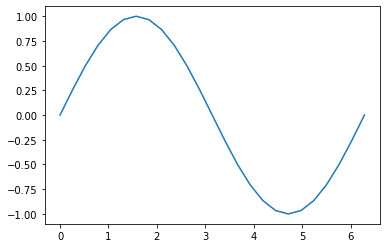

In [5]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

Echemos un vistazo más de cerca al tensor ``b``. Cuando lo imprimimos, vemos un indicador de que está rastreando su historia de cálculo:


In [6]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward>)



Este ``grad_fn`` nos da una pista de que cuando se ejecuta el paso de retropropagación(backpropagation) y calcular gradientes, tendremos que calcular el derivada de $\sin(x)$ para todas las entradas de este tensor.

Vamos a realizar algunos cálculos más:




In [7]:
c = 2 * b
print(c)

d = c + 1
print(d)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


Por último, calculemos una salida de un solo elemento. Cuando se llama a ``.backward()`` en un tensor sin argumentos, se espera que el tensor de llamada contenga sólo un elemento único, como ocurre cuando se calcula una función de pérdida.



In [8]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


Cada ``grad_fn`` almacenada con nuestros tensores te permite recorrer el cálculo hasta sus entradas con su propiedad ``next_functions``. Podemos ver a continuación que la exploración de esta propiedad en ``d`` nos muestra las funciones de gradiente para todos los tensores anteriores. Observa que ``a.grad_fn`` aparece como ``None``, indicando que era una entrada a la función sin historia propia.



In [9]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x000001B6DEECBF40>, 0), (None, 0))
((<SinBackward object at 0x000001B6DEECBD00>, 0), (None, 0))
((<AccumulateGrad object at 0x000001B6BF7E9340>, 0),)
()

c:

b:

a:
None


Con toda esta maquinaria en marcha, ¿cómo sacamos las derivadas? Llamas al método ``backward()`` en la salida, y compruebas la propiedad ``grad`` de la entrada para inspeccionar los gradientes:



tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


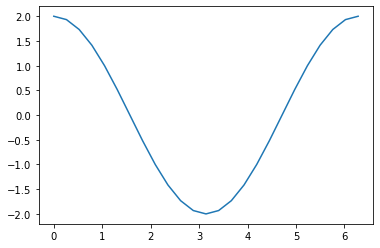

In [10]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())

## Activar y desactivar Autograd

Hay situaciones en las que necesitará un control preciso sobre la activación del autograd. Hay varias maneras de hacerlo, dependiendo de la situación.

La más simple es cambiar la bandera ``requires_grad`` en un tensor directamente:




In [11]:
a = torch.ones(2, 3, requires_grad=True)
print(a)

b1 = 2 * a
print(b1)

a.requires_grad = False
b2 = 2 * a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


En la celda anterior, vemos que b1 tiene un ``grad_fn`` (es decir, una historia de cálculo trazada), que es lo que esperamos, ya que se derivó de un tensor, ``a``, que tenía autograd activado. Cuando desactivamos ``autograd`` explícitamente con ``a.requires_grad = False``, la historia del cálculo ya no se rastrea, como vemos cuando calculamos ``b2``.

Si sólo necesita ``autograd`` apagado temporalmente, una mejor manera es utilizar la ``torch.no_grad():``




In [12]:
a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = a + b
print(c1)

with torch.no_grad():
    c2 = a + b

print(c2)

c3 = a * b
print(c3)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)


``torch.no_grad()`` también puede utilizarse como decorador de funciones o métodos:




In [13]:
def add_tensors1(x, y):
    return x + y

@torch.no_grad()
def add_tensors2(x, y):
    return x + y


a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_tensors1(a, b)
print(c1)

c2 = add_tensors2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


Hay un gestor de contexto correspondiente, ``torch.enable_grad()``, para activar autograd cuando aún no lo está. También puede usarse como decorador.

Finalmente, puedes tener un ``tensor`` que requiera seguimiento de gradiente, pero quieres una copia que no lo requiera. Para esto tenemos el método ``detach()`` del objeto Tensor - crea una copia del tensor que se separa de la historia del cálculo:



In [14]:
x = torch.rand(5, requires_grad=True)
y = x.detach()

print(x)
print(y)

tensor([0.4529, 0.1175, 0.6566, 0.4978, 0.5896], requires_grad=True)
tensor([0.4529, 0.1175, 0.6566, 0.4978, 0.5896])


Hicimos esto arriba cuando quisimos graficar algunos de nuestros tensores. Esto es porque ``matplotlib`` espera un ``array NumPy`` como entrada, y la conversión implícita de un ``tensor PyTorch`` a un ``array NumPy`` no está habilitada para tensores con ``requires_grad=True``. Hacer una copia separada nos permite seguir adelante.


## Autograd y Operaciones In-place

En todos los ejemplos de este cuaderno hasta ahora, hemos utilizado variables para capturar los valores intermedios de un cálculo. ``Autograd`` necesita estos valores intermedios para realizar cálculos de gradiente. Por esta razón, debes tener cuidado con el uso de operaciones ``in-place`` cuando utilices ``autograd``. Una operación In-place es una operación que cambia directamente el contenido de un tensor dado sin hacer una copia. Las operaciones inplace en pytorch siempre tienen un postfijo _, como .add_() o .scatter_(). Las operaciones de Python como += o *= también son operaciones in situ. Hacerlo puede destruir la información que necesitas para calcular las derivadas en el ``backward()``. ``PyTorch`` incluso te detendrá si intentas una operación in-place en una variable de hoja que requiere autograd, como se muestra a continuación.



In [4]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
torch.sin_(a)



RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

## Autograd Profiler

``Autograd`` rastrea cada paso de su cálculo en detalle. Tal historial de cómputo, combinado con la información de tiempo, sería un generador de perfiles útil, y autograd tiene esa función integrada. Aquí hay un ejemplo rápido de uso:



In [18]:
device = torch.device('cpu')
run_on_gpu = False
if torch.cuda.is_available():
    device = torch.device('cuda')
    run_on_gpu = True
    
x = torch.randn(2, 3, requires_grad=True)
y = torch.rand(2, 3, requires_grad=True)
z = torch.ones(2, 3, requires_grad=True)

with torch.autograd.profiler.profile(use_cuda=run_on_gpu) as prf:
    for _ in range(1000):
        z = (z / x) * y
        
print(prf.key_averages().table(sort_by='self_cpu_time_total'))

---------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
           Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
---------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
      aten::div        48.49%      36.122ms        50.69%      37.755ms      37.755us      38.639ms        50.92%      38.639ms      38.639us          1000  
      aten::mul        47.22%      35.175ms        49.31%      36.733ms      36.733us      37.246ms        49.08%      37.246ms      37.246us          1000  
    aten::empty         4.28%       3.192ms         4.28%       3.192ms       1.596us       0.000us         0.00%       0.000us       0.000us          2000  
---------------  ------------  ------------  ------

El generador de perfiles también puede etiquetar subbloques individuales de código, desglosar
datos por forma de tensor de entrada y exportar datos como herramientas de seguimiento de Chrome
archivo. Para obtener detalles completos de la API, consulte el
[documentación](https://pytorch.org/docs/stable/autograd.html#profiler)_.

## Tema avanzado: más detalles de Autograd y la API de alto nivel

Si tiene una función con una entrada n-dimensional y m-dimensional
salida, $\vec{y}=f(\vec{x})$, el gradiente completo es una matriz de
la derivada de cada salida con respecto a cada entrada, llamada
*jacobiano:*

\begin{align}J
     =
     \left(\begin{array}{ccc}
     \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
     \vdots & \ddots & \vdots\\
     \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
     \end{array}\right)\end{align}

Si tiene una segunda función, $l=g\left(\vec{y}\right)$ que
toma una entrada m-dimensional (es decir, la misma dimensionalidad que la
salida anterior) y devuelve una salida escalar, puede expresar sus
gradientes con respecto a $\vec{y}$ como vector columna,
$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$
- que en realidad es solo un jacobiano de una columna.

Más concretamente, imagine la primera función como su modelo PyTorch (con potencialmente muchas entradas y muchas salidas) y la segunda función como una función de pérdida (con la salida del modelo como entrada y el valor de pérdida como salida escalar).

Si multiplicamos el jacobiano de la primera función por el gradiente de la segunda función y aplicamos la regla de la cadena, obtenemos:


\begin{align}J^{T}\cdot v=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\left(\begin{array}{c}
   \frac{\partial l}{\partial y_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial y_{m}}
   \end{array}\right)=\left(\begin{array}{c}
   \frac{\partial l}{\partial x_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial x_{n}}
   \end{array}\right)\end{align}

Nota: también podría usar la operación equivalente $v^{T}\cdot J$,
y recuperar un vector de fila.

El vector columna resultante es el *gradiente de la segunda función con
respecto a las entradas del primero* - o en el caso de nuestro modelo y
función de pérdida, el gradiente de la pérdida con respecto al modelo
entradas.

**``torch.autograd`` es un motor para computar estos productos.** Este
es cómo acumulamos los gradientes sobre los pesos de aprendizaje durante el
pase hacia atrás.

Por esta razón, la llamada ``hacia atrás()`` puede *también* tomar una opción
entrada vectorial. Este vector representa un conjunto de gradientes sobre el tensor,
que se multiplican por el jacobiano del tensor trazado por autograd que
lo precede. Probemos un ejemplo específico con un vector pequeño:



In [19]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([ -748.8833, -1573.7837,  -336.0165], grad_fn=<MulBackward0>)


Si intentáramos llamar a ``y.backward()`` ahora, obtendríamos un error de tiempo de ejecución y un
mensaje de que los gradientes solo se pueden calcular *implícitamente* para escalar
salidas. Para una salida multidimensional, autograd espera que proporcionemos
gradientes para esas tres salidas que puede multiplicar en el
jacobiano:



In [20]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float) # stand-in for gradients
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


(Tenga en cuenta que los gradientes de salida están todos relacionados con potencias de dos, que
esperaríamos de una operación de duplicación repetida.)

### La API de alto nivel

Hay una API en autograd que le brinda acceso directo a importantes
operaciones diferenciales con matrices y vectores. En particular, le permite
para calcular las matrices jacobiana y *hessiana* de una determinada
función para entradas particulares. (El hessiano es como el jacobiano, pero
expresa todas las derivadas *segunda* parciales.) También proporciona métodos
para tomar productos vectoriales con estas matrices.

Tomemos el jacobiano de una función simple, evaluada para un 2
entradas de un solo elemento:




In [21]:
def exp_adder(x, y):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.0204]), tensor([0.7157]))


(tensor([[2.0412]]), tensor([[3.]]))

Si miras de cerca, la primera salida debería ser igual a $2e^x$ (ya que
la derivada de $e^x$ es $e^x$), y el segundo valor
debería ser 3.

Por supuesto, puede hacer esto con tensores de orden superior:



In [22]:
inputs = (torch.rand(3), torch.rand(3)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.4203, 0.8772, 0.5600]), tensor([0.7472, 0.7861, 0.6246]))


(tensor([[3.0449, 0.0000, 0.0000],
         [0.0000, 4.8083, 0.0000],
         [0.0000, 0.0000, 3.5015]]),
 tensor([[3., 0., 0.],
         [0., 3., 0.],
         [0., 0., 3.]]))

El método ``torch.autograd.funcional.hessian()`` funciona de manera idéntica
(suponiendo que su función es dos veces diferenciable), pero devuelve una matriz
de todas las segundas derivadas.

También hay una función para calcular directamente el vector-jacobiano
producto, si proporciona el vector:




In [23]:
def do_some_doubling(x):
    y = x * 2
    while y.data.norm() < 1000:
        y = y * 2
    return y

inputs = torch.randn(3)
my_gradients = torch.tensor([0.1, 1.0, 0.0001])
torch.autograd.functional.vjp(do_some_doubling, inputs, v=my_gradients)

(tensor([-947.6455, -182.5196, -661.6850]),
 tensor([2.0480e+02, 2.0480e+03, 2.0480e-01]))

El método ``torch.autograd.funcional.jvp()`` realiza la misma matriz
multiplicación como ``vjp()`` con los operandos invertidos. El ``vhp()``
y los métodos ``hvp()`` hacen lo mismo para un producto vectorial-hessiano.

Para obtener más información, incluidas las notas de rendimiento en los [docs for the
funcional
API](https://pytorch.org/docs/stable/autograd.html#function-higher-level-api)_



